In [11]:
from collections import defaultdict, Counter
import os, itertools, copy, datetime, importlib, logging
from tqdm.auto import tqdm
from pathlib import Path
from util import config_logger

import numpy as np
import pandas as pd
from umap import UMAP
from anndata import AnnData
import scanpy as sc

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

logger = config_logger(logging.getLogger(__name__))

In [12]:
path2root = Path(f'/work/magroup/xinyuelu/AD-proj')

In [13]:
def reload_all():
    import utils, utils_plotting
    importlib.reload(utils)
    importlib.reload(utils_plotting)

reload_all()

In [14]:
reload_all()
from utils import load_chrom_size
chrom_size = load_chrom_size()
print(chrom_size)

{'hg38_chr1': 248956422, 'hg38_chr2': 242193529, 'hg38_chr3': 198295559, 'hg38_chr4': 190214555, 'hg38_chr5': 181538259, 'hg38_chr6': 170805979, 'hg38_chr7': 159345973, 'hg38_chrX': 156040895, 'hg38_chr8': 145138636, 'hg38_chr9': 138394717, 'hg38_chr11': 135086622, 'hg38_chr10': 133797422, 'hg38_chr12': 133275309, 'hg38_chr13': 114364328, 'hg38_chr14': 107043718, 'hg38_chr15': 101991189, 'hg38_chr16': 90338345, 'hg38_chr17': 83257441, 'hg38_chr18': 80373285, 'hg38_chr20': 64444167, 'hg38_chr19': 58617616, 'hg38_chrY': 57227415, 'hg38_chr22': 50818468, 'hg38_chr21': 46709983, 'hg38_chrM': 16569, 'mm10_chr1': 195471971, 'mm10_chr2': 182113224, 'mm10_chrX': 171031299, 'mm10_chr3': 160039680, 'mm10_chr4': 156508116, 'mm10_chr5': 151834684, 'mm10_chr6': 149736546, 'mm10_chr7': 145441459, 'mm10_chr10': 130694993, 'mm10_chr8': 129401213, 'mm10_chr14': 124902244, 'mm10_chr9': 124595110, 'mm10_chr11': 122082543, 'mm10_chr13': 120421639, 'mm10_chr12': 120129022, 'mm10_chr15': 104043685, 'mm10_ch

In [15]:
%%time
reload_all()
from utils import Library

lib_index = 1
lib_DNA, lib_RNA = f'hPFC-scHiC-lib-{lib_index}', f'hPFC-scRNA-lib-{lib_index}'
lib_name = f'hPFC-lib-{lib_index}'
batch = '202409'
walk_policy = "complete"

obj = Library(lib_DNA, lib_RNA, f'{lib_name}_{walk_policy}', path2root)
obj.load_RNA(path2root / 'results' / 'results_rna' / batch / f'RNA_{lib_RNA}.pkl')
obj.load_DNA(path2root / 'results' / 'results_hic_complete' / batch / f'contact_{lib_DNA}.pkl')
obj.calc_all_in_one()
obj.raw = obj

2024-10-14 09:39:03:INFO:# of cells: 9216
2024-10-14 09:39:03:INFO:Loading /work/magroup/xinyuelu/AD-proj/results/results_rna/202409/RNA_hPFC-scRNA-lib-1.pkl
2024-10-14 09:39:04:INFO:Loaded 32352 genes, 5055551 cell-gene, and 31708628 mRNAs
2024-10-14 09:39:04:INFO:Loading /work/magroup/xinyuelu/AD-proj/results/results_hic_complete/202409/contact_hPFC-scHiC-lib-1.pkl
2024-10-14 09:39:07:INFO:Loaded 25 chroms and 473106833 contacts
2024-10-14 09:39:07:INFO:Calculating DNA coverage
2024-10-14 09:39:33:INFO:Done
2024-10-14 09:39:33:INFO:Calculating DNA coverage nnz
2024-10-14 09:40:54:INFO:Done
2024-10-14 09:40:54:INFO:Calculating DNA long/short interactions
2024-10-14 09:43:16:INFO:Done
2024-10-14 09:43:17:INFO:Calculating DNA cis/trans ratio
2024-10-14 09:44:04:INFO:Done
2024-10-14 09:44:04:INFO:Calculating DNA mitosis band:short
2024-10-14 09:47:11:INFO:Done
2024-10-14 09:47:12:INFO:Calculating RNA coverage
2024-10-14 09:47:13:INFO:Done


1
CPU times: user 2min 34s, sys: 48.6 s, total: 3min 22s
Wall time: 8min 9s


In [16]:
# %%time
reload_all()
from utils import Library
from utils_plotting import plot_mapping_statistics, plot_RNA_statistics, plot_DNA_coverage

obj = obj.raw
thrs = {
    'RNA coverage mRNA': int(3e3),
    'RNA coverage %mito': (0, 0.05),
    'DNA coverage all': int(1e5),
}
obj.filter_cell(chrom_size=chrom_size, thrs=thrs, species_list=['hg38'])

2024-10-14 09:49:55:INFO:Filtering for RNA hg38
2024-10-14 09:49:55:INFO:Filtering for DNA hg38
2024-10-14 09:49:55:INFO:species  DNA species  RNA species
empty    empty        empty          7576
                      hg38            143
         hg38         empty           491
hg38     hg38         hg38           1006
dtype: int64


2024-10-14 09:50:05:INFO:Saving to /work/magroup/xinyuelu/AD-proj/figures-stats-overall/202409/stats_hPFC-lib-1_complete.png


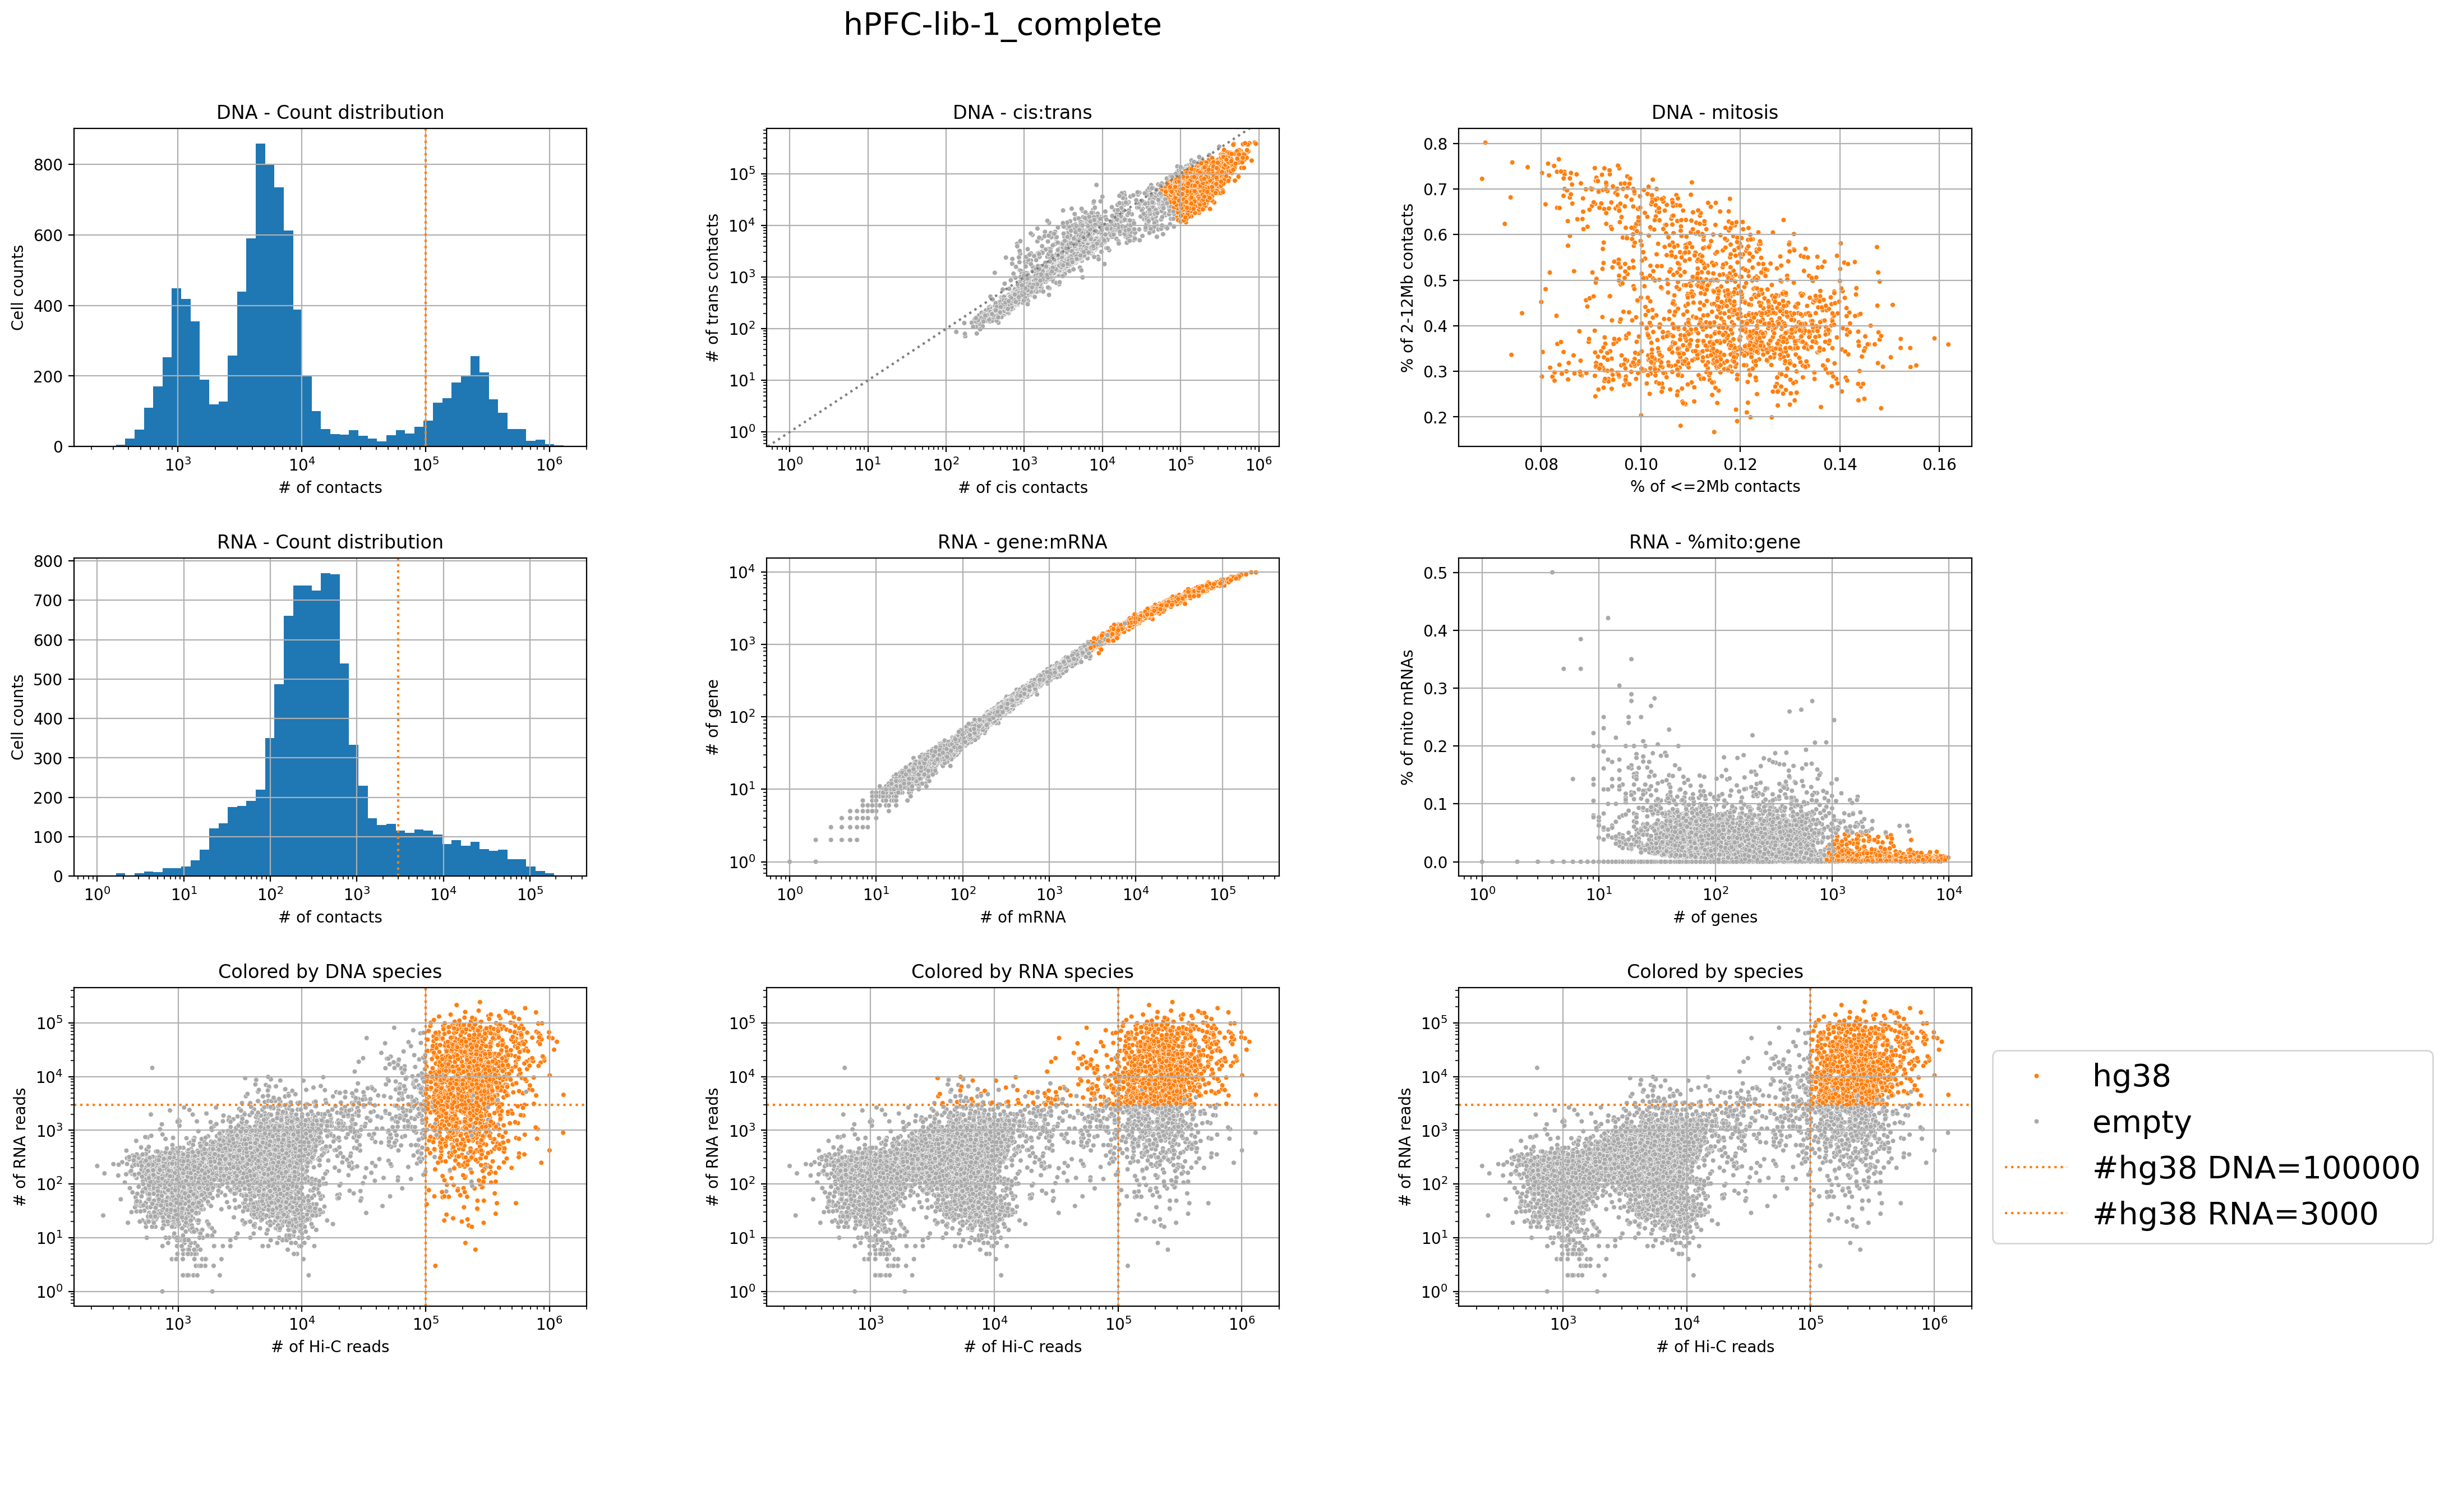

2024-10-14 09:51:55:INFO:Saving to /work/magroup/xinyuelu/AD-proj/figures-stats-rna/202409/stats_hPFC-lib-1_complete.png


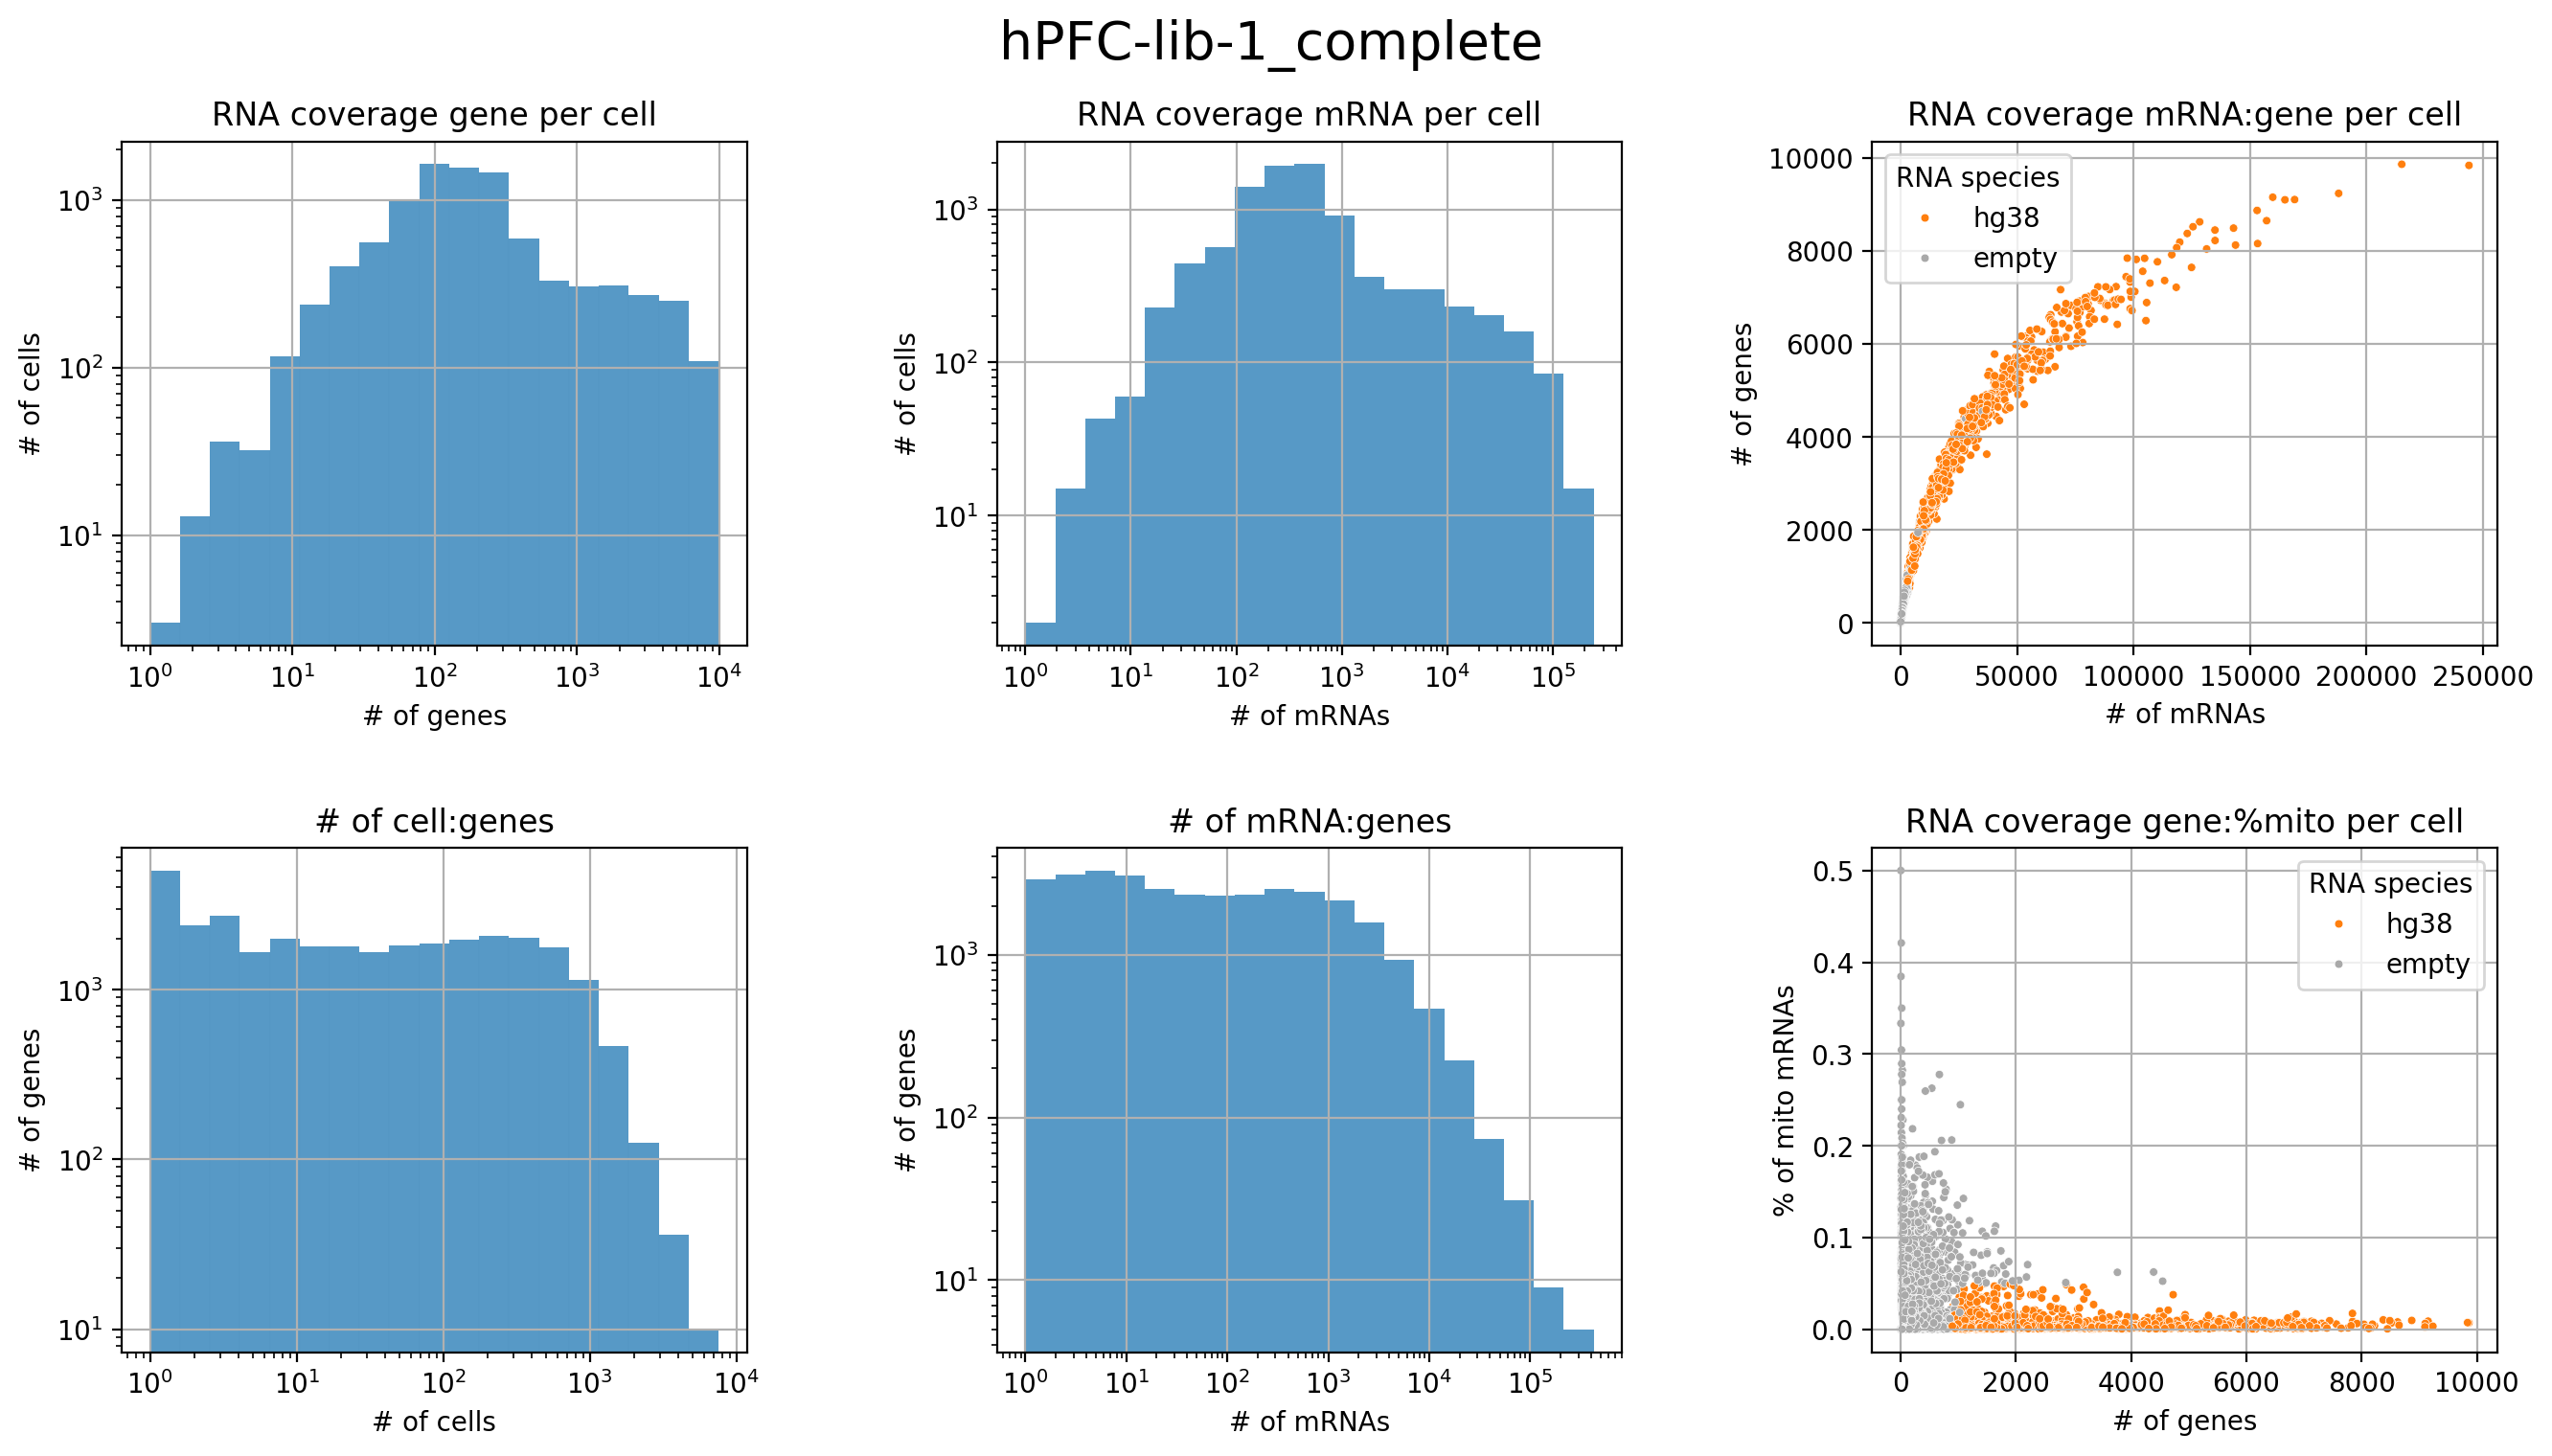

2024-10-14 09:52:54:INFO:Saving to /work/magroup/xinyuelu/AD-proj/figures-stats-dna/202409/stats_hPFC-lib-1_complete.png


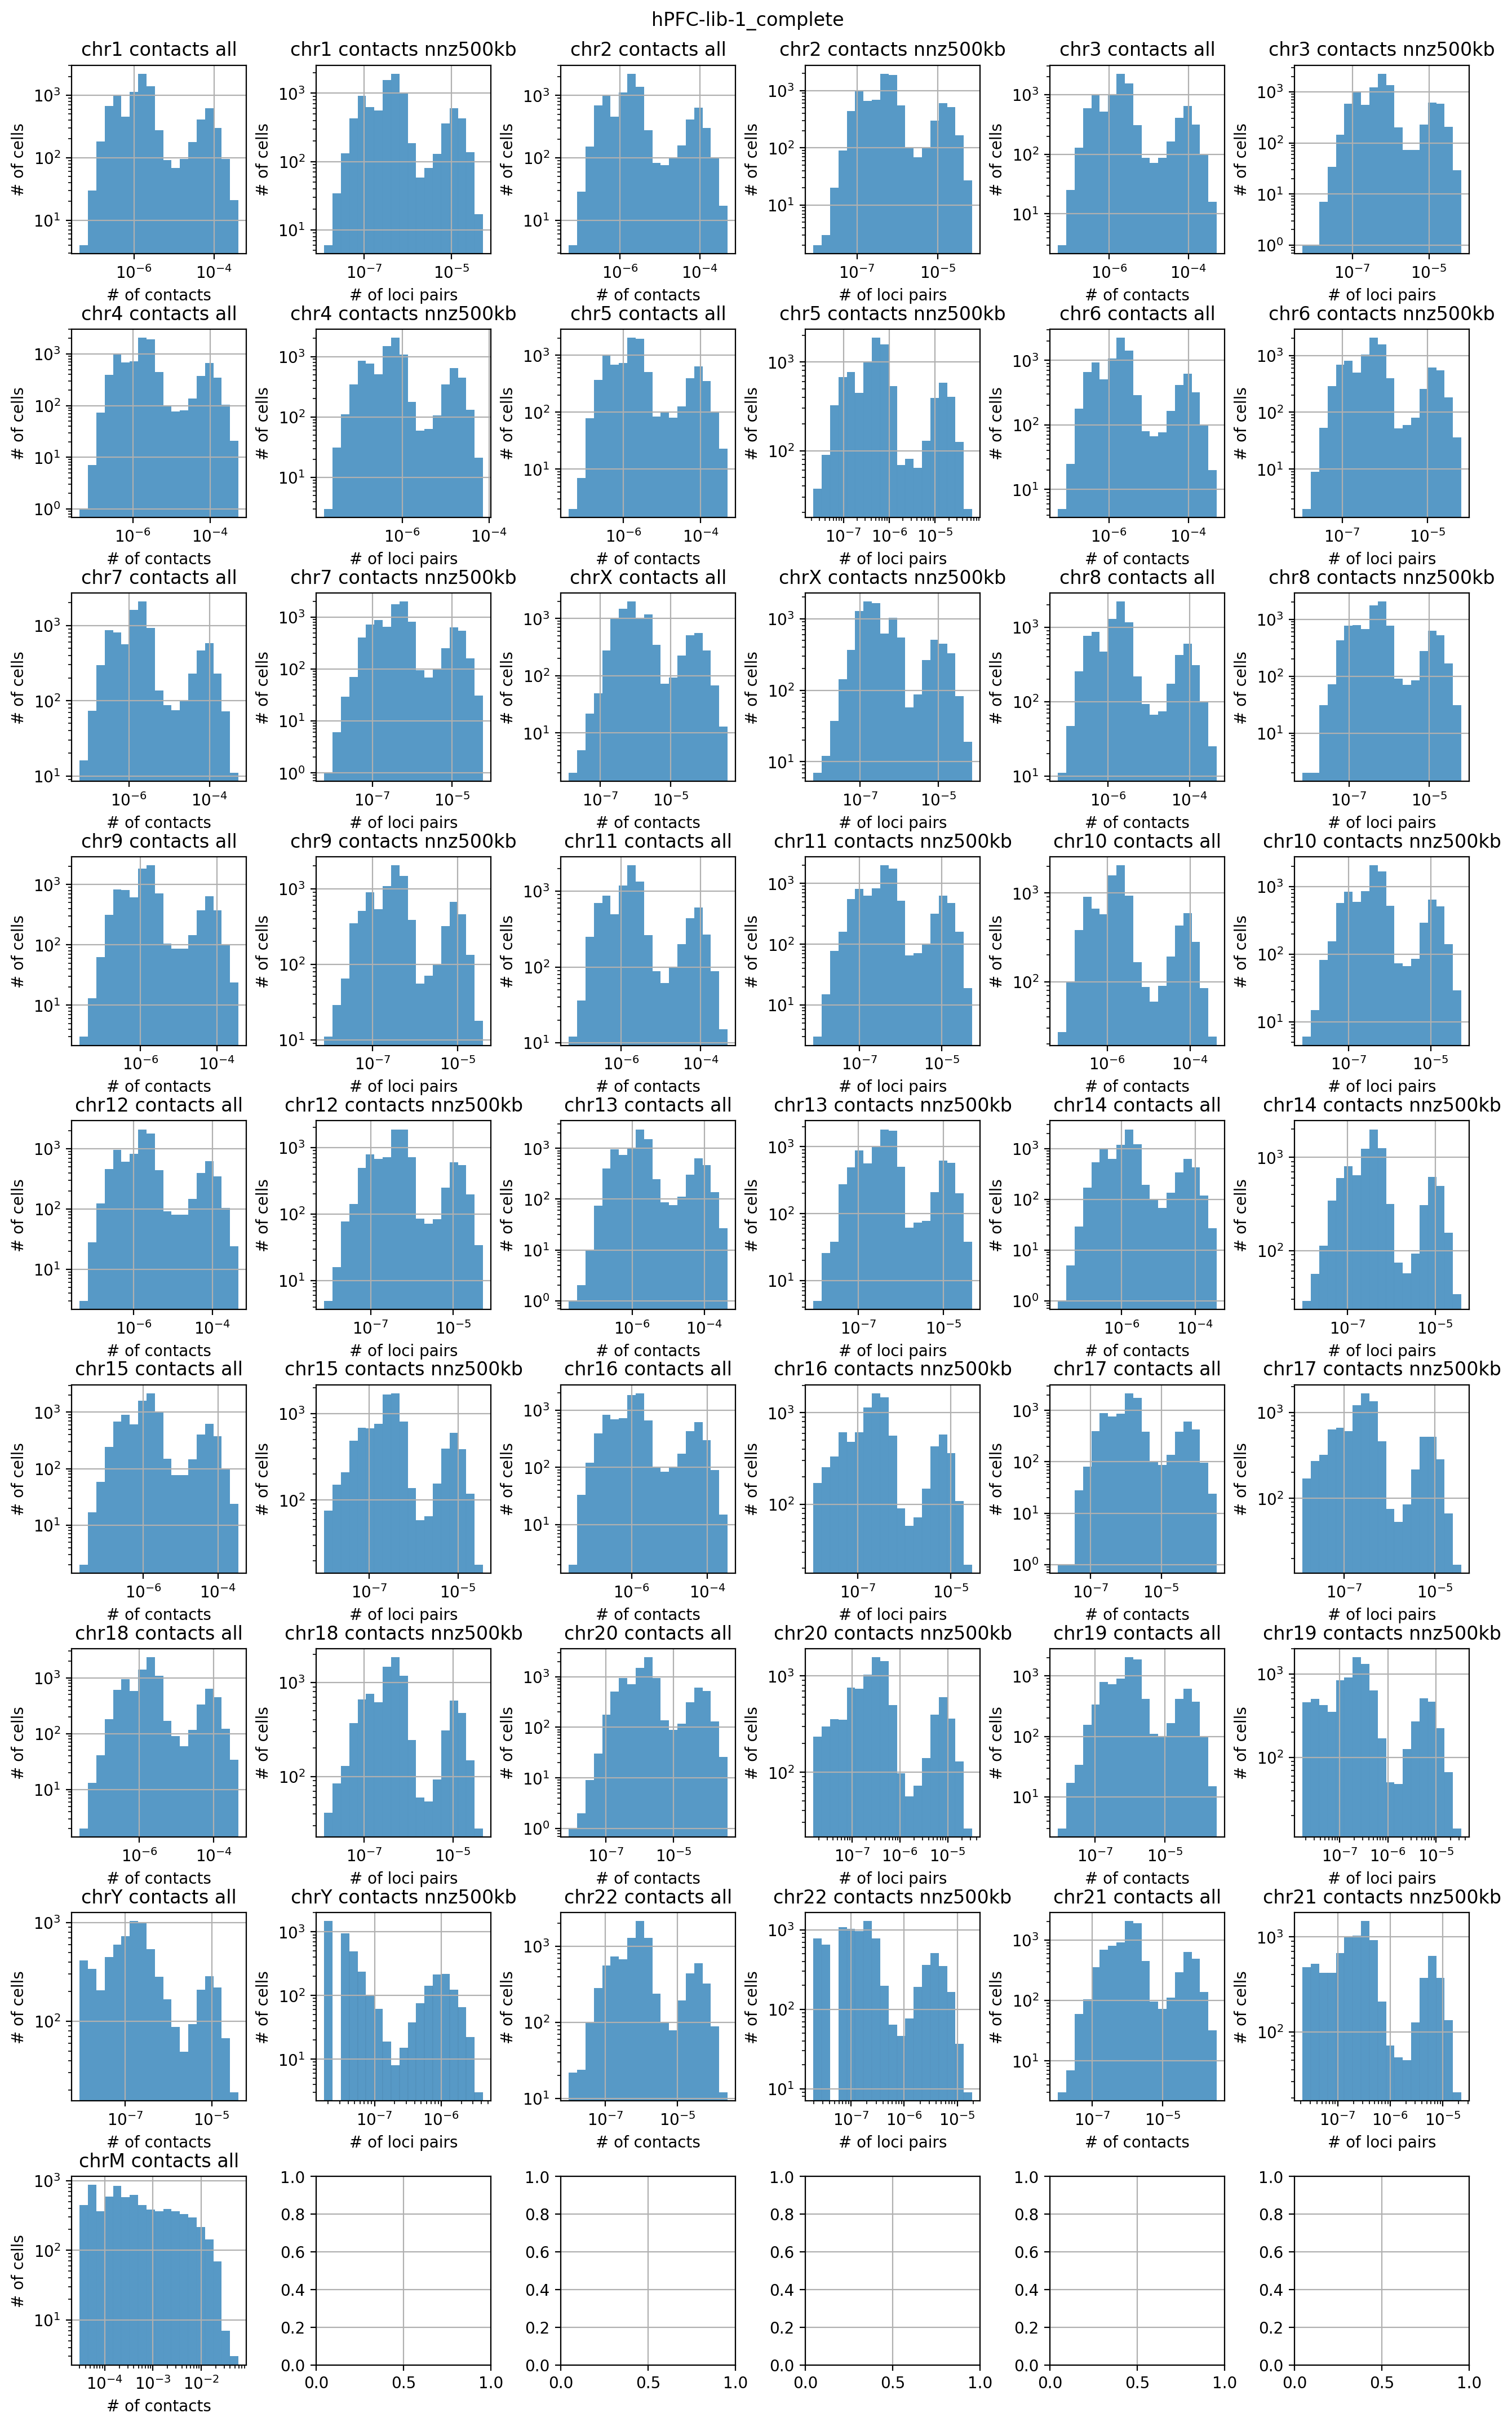

In [17]:
reload_all()
from utils_plotting import plot_mapping_statistics, plot_RNA_statistics, plot_DNA_coverage
plot_mapping_statistics(obj, thrs=thrs, spec='hg38', batch=batch)
plot_RNA_statistics(obj, spec='hg38', batch=batch)
plot_DNA_coverage(obj, chrom_size, spec='hg38', batch=batch)

In [18]:
df = pd.concat(
    [obj.meta.groupby(k).size().rename(k) for k in ['DNA species', 'RNA species', 'species']],
    axis=1,
).T
display(df)
df = df[['hg38']]
print('\n'.join('\t'.join(map(str, _)) for _ in df.values))

,empty,hg38
DNA species,7719,1497
RNA species,8067,1149
species,8210,1006


1497
1149
1006


In [19]:
%%time
reload_all()

species_list = [
     'hg38',
]

objs_species = {('complete', s): copy.deepcopy(obj) for s in species_list}
print(objs_species)
for (walk_policy, species), obj in objs_species.items():
    obj.lib_name = '_'.join([obj.lib_name, species, 'filtered'])

{('complete', 'hg38'): <backend.Library object at 0x7f05d080b2e0>}
CPU times: user 16.8 s, sys: 6.32 s, total: 23.1 s
Wall time: 57.3 s


In [20]:
hg38_chrom_size = {}
for k,v in chrom_size.items():
    if k.split("_")[0] == "hg38":
        hg38_chrom_size[k.split("_")[-1]] = v
print(hg38_chrom_size)

{'chr1': 248956422, 'chr2': 242193529, 'chr3': 198295559, 'chr4': 190214555, 'chr5': 181538259, 'chr6': 170805979, 'chr7': 159345973, 'chrX': 156040895, 'chr8': 145138636, 'chr9': 138394717, 'chr11': 135086622, 'chr10': 133797422, 'chr12': 133275309, 'chr13': 114364328, 'chr14': 107043718, 'chr15': 101991189, 'chr16': 90338345, 'chr17': 83257441, 'chr18': 80373285, 'chr20': 64444167, 'chr19': 58617616, 'chrY': 57227415, 'chr22': 50818468, 'chr21': 46709983, 'chrM': 16569}


In [22]:
# %%time
reload_all()
from utils_plotting import plot_mapping_statistics, plot_RNA_statistics, plot_DNA_coverage

species = 'hg38'
if species == 'mm10':
    chrom_list = [f'chr{i}' for i in itertools.chain(range(1, 20), 'XYM')]
elif species == 'hg38':
    chrom_list = [f'chr{i}' for i in itertools.chain(range(1, 23), 'XYM')]
else:
    assert False
obj = objs_species[('complete', species)]
thrs = {
    'RNA coverage mRNA': int(3e3),
    'RNA coverage %mito': (0, 0.05),
    'DNA coverage all': int(1e5),
}
obj.filter_cell(chrom_size={k: v for k, v in hg38_chrom_size.items() if k in chrom_list and k[-1].isdigit()}, thrs=thrs, species_list=(species,))
display(pd.concat(
    [obj.meta.groupby(k).size().rename(k) for k in ['DNA species', 'RNA species', 'species']],
    axis=1,
).T.fillna(0).astype(int))

2024-10-14 10:00:27:INFO:Filtering for RNA hg38
2024-10-14 10:00:27:INFO:Filtering for DNA hg38
2024-10-14 10:00:27:INFO:species  DNA species  RNA species
empty    empty        empty          7576
                      hg38            143
         hg38         empty           491
hg38     hg38         hg38           1006
dtype: int64


,empty,hg38
DNA species,7719,1497
RNA species,8067,1149
species,8210,1006


In [23]:
for (w, s), o in objs_species.items():
    if s != species: continue
    o.subset(
        cell_mask=o.meta['species'].values == species,
        chrom_mask=np.isin(o.chrom_i2a, chrom_list),
        species=(species,),
    )
    o.calc_all_in_one()

2024-10-14 10:02:41:INFO:Keeping columns `['DNA species' 'RNA species' 'species']`
2024-10-14 10:02:41:INFO:Calculating DNA coverage
2024-10-14 10:03:32:INFO:Done
2024-10-14 10:03:33:INFO:Calculating DNA coverage nnz
2024-10-14 10:05:58:INFO:Done
2024-10-14 10:05:58:INFO:Calculating DNA long/short interactions
2024-10-14 10:07:14:INFO:Done
2024-10-14 10:07:14:INFO:Calculating DNA cis/trans ratio
2024-10-14 10:07:46:INFO:Done
2024-10-14 10:07:46:INFO:Calculating DNA mitosis band:short
2024-10-14 10:09:20:INFO:Done
2024-10-14 10:09:21:INFO:Calculating RNA coverage
2024-10-14 10:09:22:INFO:Done


1


## save

In [24]:
for (w, s), o in objs_species.items():
    logger.info(' '.join(map(str, [w, s, o.meta.shape, o.num_cells, o.num_genes, o.num_chroms])))
    o.save_meta(path2root / 'results' / 'results' / f'meta_{o.lib_name}.pkl')
    o.save_meta(path2root / 'results' / 'results' / f'meta_{o.lib_name}.csv')
    o.save_RNA(path2root / 'results' / 'results' / f'RNA_{o.lib_name}.pkl')
    o.save_DNA(path2root / 'results' / 'results' / f'contact_{o.lib_name}.pkl')

2024-10-14 10:12:15:INFO:complete hg38 (1006, 200) 1006 30679 25
2024-10-14 10:12:15:INFO:Saving to /work/magroup/xinyuelu/AD-proj/results/results/meta_hPFC-lib-1_complete_hg38_filtered.pkl
2024-10-14 10:12:15:INFO:Done
2024-10-14 10:12:15:INFO:Saving to /work/magroup/xinyuelu/AD-proj/results/results/meta_hPFC-lib-1_complete_hg38_filtered.csv
2024-10-14 10:12:16:INFO:Done
2024-10-14 10:12:16:INFO:Saving to /work/magroup/xinyuelu/AD-proj/results/results/RNA_hPFC-lib-1_complete_hg38_filtered.pkl
2024-10-14 10:12:16:INFO:Done
2024-10-14 10:12:16:INFO:Saving to /work/magroup/xinyuelu/AD-proj/results/results/contact_hPFC-lib-1_complete_hg38_filtered.pkl
2024-10-14 10:12:29:INFO:Done
